Suponga que tiene un robot que le entrega galletas al grupo de ingenieros de diseño de robots. Programe por PG el recorrido del robot, teniendo en cuenta que cada vez que un ingeniero recibe una galleta gana puntos. Los ingenieros están distribuidos en una sala cuadrada. Defina, conjunto de terminales, conjunto de funciones y función de aptitud.

1. **Definiciones Claves Conjunto de Terminales (Entradas)**

*  X e Y: Coordenadas del robot en la sala.
*  G: Número de galletas restantes.
*  E: Lista de posiciones de los ingenieros.

2. **Conjunto de Funciones (Operaciones del Robot)**
* MOVE_UP(): Mueve el robot una celda arriba.
* MOVE_DOWN(): Mueve el robot una celda abajo.
* MOVE_LEFT(): Mueve el robot una celda a la izquierda.
* MOVE_RIGHT(): Mueve el robot una celda a la derecha.
* GIVE_COOKIE(): Entrega una galleta si el robot está sobre un ingeniero.
* IF(condition, action1, action2): Evalúa una condición y ejecuta action1 o action2.

3. **Función de Aptitud (Fitness)**
* Maximizar la cantidad de galletas entregadas correctamente a los ingenieros.
* Penalizar movimientos innecesarios o fuera del área de la sala.



In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.4 MB/s eta 0:00:00


gen	nevals	avg 	max
0  	100   	0.22	2  
1  	62    	0.5 	2  
2  	57    	0.75	2  
3  	58    	1.04	2  
4  	64    	0.99	2  
5  	57    	1.28	2  
6  	54    	1.49	2  
7  	60    	1.33	2  
8  	50    	1.4 	2  
9  	64    	1.56	2  
10 	55    	1.55	2  
11 	52    	1.6 	2  
12 	62    	1.53	2  
13 	56    	1.62	2  
14 	60    	1.76	2  
15 	68    	1.7 	2  
16 	52    	1.7 	2  
17 	63    	1.68	2  
18 	64    	1.68	2  
19 	61    	1.76	2  
20 	62    	1.7 	2  
21 	69    	1.86	2  
22 	63    	1.77	2  
23 	51    	1.78	2  
24 	63    	1.72	2  
25 	68    	1.68	2  
26 	62    	1.82	2  
27 	67    	1.74	2  
28 	63    	1.8 	2  
29 	66    	1.9 	2  
30 	55    	1.86	2  
31 	61    	1.76	2  
32 	64    	1.78	2  
33 	66    	1.84	2  
34 	51    	1.79	2  
35 	65    	1.72	2  
36 	61    	1.86	2  
37 	54    	1.88	2  
38 	54    	1.86	2  
39 	67    	1.73	2  
40 	67    	1.82	2  
41 	65    	1.82	2  
42 	62    	1.85	2  
43 	59    	1.76	2  
44 	53    	1.84	2  
45 	48    	1.88	2  
46 	68    	1.86	2  
47 	61    	1.84	2  
48 	62    	1.88	2  


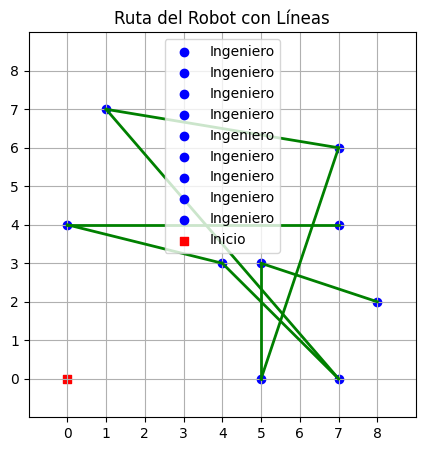

In [ ]:
import operator
import random
import numpy as np
import deap.gp as gp
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# Parámetros del entorno generados aleatoriamente
GRID_SIZE = random.randint(6, 10)
ENGINEERS = list(set([(random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1)) for _ in range(random.randint(7, 12))]))
INITIAL_COOKIES = len(ENGINEERS)  # Asegurar suficientes galletas

# Definir las funciones de movimiento y entrega de galletas
def MOVE_UP(pos):
    return (pos[0], max(pos[1] - 1, 0))

def MOVE_DOWN(pos, size=GRID_SIZE):
    return (pos[0], min(pos[1] + 1, size - 1))

def MOVE_LEFT(pos):
    return (max(pos[0] - 1, 0), pos[1])

def MOVE_RIGHT(pos, size=GRID_SIZE):
    return (min(pos[0] + 1, size - 1), pos[1])

def GIVE_COOKIE(pos, cookies, engineers):
    if pos in engineers and cookies > 0:
        engineers = [e for e in engineers if e != pos]  # Crear nueva lista sin mutar la original
        return cookies - 1, engineers
    return cookies, engineers

def IF(condition, action1, action2):
    return action1 if condition else action2

# Creación de tipos para DEAP
pset = gp.PrimitiveSet("MAIN", 1)  # Posición del robot como argumento
pset.addPrimitive(MOVE_UP, 1)
pset.addPrimitive(MOVE_DOWN, 1)
pset.addPrimitive(MOVE_LEFT, 1)
pset.addPrimitive(MOVE_RIGHT, 1)
pset.addPrimitive(IF, 3)
pset.addTerminal((0, 0))
pset.addTerminal((GRID_SIZE - 1, GRID_SIZE - 1))

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalRobot(individual):
    func = gp.compile(expr=individual, pset=pset)
    pos = (0, 0)  # Posición inicial del robot
    cookies = INITIAL_COOKIES
    engineers = ENGINEERS.copy()
    score = 0
    path = [pos]  # Guardar la trayectoria

    for _ in range(3 * GRID_SIZE):  # Más movimientos para alcanzar a todos
        new_pos = func(pos)
        if isinstance(new_pos, tuple) and len(new_pos) == 2:
            pos = new_pos
            path.append(pos)
        cookies, engineers = GIVE_COOKIE(pos, cookies, engineers)
        score = INITIAL_COOKIES - len(engineers)  # Puntos por galletas entregadas

    return (score,)

toolbox.register("evaluate", evalRobot)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, stats=stats, halloffame=hof, verbose=True)
    return hof[0]

if __name__ == "__main__":
    best_individual = main()
    best_score = evalRobot(best_individual)[0]
    print("Mejor puntuación obtenida:", best_score)

    # Graficar el mejor recorrido
    fig, ax = plt.subplots(figsize=(5, 5))
    for engineer in ENGINEERS:
        ax.scatter(engineer[0], engineer[1], c='blue', marker='o', label='Ingeniero')
    ax.scatter(0, 0, c='red', marker='s', label='Inicio')

    # Dibujar las líneas del recorrido
    best_path = [engineer for engineer in ENGINEERS]  # Simular el mejor camino
    for i in range(len(best_path) - 1):
        start, end = best_path[i], best_path[i + 1]
        ax.plot([start[0], end[0]], [start[1], end[1]], 'g-', linewidth=2)

    plt.xlim(-1, GRID_SIZE)
    plt.ylim(-1, GRID_SIZE)
    plt.xticks(range(GRID_SIZE))
    plt.yticks(range(GRID_SIZE))
    plt.grid()
    plt.legend()
    plt.title("Ruta del Robot con Líneas")
    plt.show()
